In [1]:
import tensorflow as tf
import numpy as np
import primo.tools.sequences as seqtools

In [2]:
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mqp6ilm5 because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
first_time_point = 12
last_time_point = 60000
first_time_point_cleavage_rate = np.log(2)/first_time_point
last_time_point_cleavage_rate = np.log(2)/last_time_point
log10_ub = np.log10(first_time_point_cleavage_rate)
log10_lb = np.log10(last_time_point_cleavage_rate)
data_span = log10_ub - log10_lb

def bandpass_hinge(x):
    return tf.maximum(log10_lb, tf.minimum(x, log10_ub))

def log10_crispr_spec(seq_pairs, subpen, subtrans):
    
    # ensure that sequence pairs have dimension: (batch, 2 sequences, 20 nt, 4 channels)
    seq_pairs.shape.assert_is_compatible_with([None, 2, 20, 4])
    seq_len = seq_pairs.shape[2]

    # separate first and sequences from each pair
    ref = seq_pairs[:, 0, :, :]
    obs = seq_pairs[:, 1, :, :]

    # computes the outer product of one-hot vectors at each position for each pair
    # for syntax see https://numpy.org/doc/stable/reference/generated/numpy.einsum.html
    subst_ids = tf.einsum('...i,...j->...ij', ref, obs)

    # turn 4x4 match matrix into 1x16 vector
    subst_ids_flat = tf.reshape(subst_ids, [-1, seq_len, 16])
    
    # multiply by scores and take highest value
    subst_scores = tf.reduce_max(subst_ids_flat * subtrans.flatten(), -1)
    
    # compute dot product of position penalty and substitution type
    scores = tf.reduce_sum(subst_scores * subpen.flatten(), -1)
    
    # threshold final result
    return bandpass_hinge(scores + log10_ub) - log10_ub

In [4]:
subpen = np.array([-1.7449405080809126, -1.275485084790358, -1.8001827224086722, -1.9323849500279549, -1.6677722398632207, -1.6537370694565101, -1.8981469677400609, -1.0814292717607923, -1.3231152511430453, -0.99840146446464273, -1.2766126030502924, -1.073338813454068, -1.5614374592181826, -1.4737507320504855, -1.298392565410591, -1.0105000195452765, -0.43349702574711524, -0.11665543376814178, -0.17370266801790191, 0.2676084623705467, 0.051835157750172757, 0.08920809165894289, 0.075459598643889569, 0.046975071077932237])
subtrans = np.array([[ 0.        ,  1.16616601,  0.96671383,  0.94917742],       [ 0.94076049,  0.        ,  1.18426595,  0.87129983],       [ 0.58224486,  1.11064886,  0.        ,  1.04707949],       [ 0.9633753 ,  0.98895548,  1.2293125 ,  0.        ]])

In [5]:
# changes matrices to account for the nucleotide string being 'ACGT', not 'ATCG' as in seqtools.bases and the rest of the PRIMO package
finkel_bases = 'ACGT'
shift = np.array([finkel_bases.index(b) for b in seqtools.bases])
subtrans_shift = subtrans[shift,:][:, shift]
subpen_shift = subpen[:20][::-1]

In [6]:
ref_seq = "GACAGGTACAAGAAGGAGTA"

In [7]:
# makes an array of pairs, ref_seq and all possible single substitutions of that ref_seq
pairs = []
for i in range(20):
    for base in finkel_bases:
        nts_dna_seq = ref_seq[:i] + base + ref_seq[i+1:]
        pairs.append([ref_seq, nts_dna_seq])
pairs = np.array(pairs)

In [8]:
# take the array of pairs and reshape
onehot_pairs = tf.convert_to_tensor(
    seqtools.seqs_to_onehots(pairs.flatten()).reshape(-1, 2, 20, 4),
    dtype = tf.float32
)

In [9]:
# generate score for each pair
scores = log10_crispr_spec(
    onehot_pairs,
    subpen_shift,
    subtrans_shift
).numpy()

In [10]:
# make a dictionary of the score for each substitution
y_given_base = {base: [] for base in finkel_bases}
j = 0
for i in range(20):
    for base in finkel_bases:
        y_given_base[base].append(scores[j])
        j += 1

In [11]:
color_given_base = {'A': 'blue', 'C': 'darkgoldenrod', 'G': 'green', 'T': 'firebrick'}

Text(0.5, 1.0, 'Mismatches')

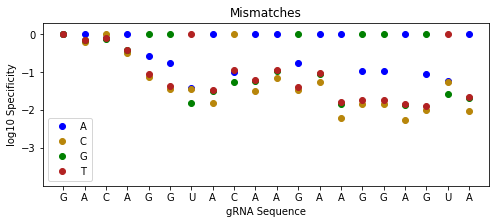

In [12]:
fig, ax = plt.subplots(figsize=(8, 3))
x = range(1, 21)
for base in finkel_bases:
    ax.plot(x, y_given_base[base], 'o', color=color_given_base[base], label=base)
ax.set_ylim((-data_span - 0.3, 0.3))
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(list(ref_seq.replace('T', 'U')))
ax.set_xlabel('gRNA Sequence')
ax.set_ylabel('log10 Specificity')
ax.set_title('Mismatches')